# Homework 3

## Problem 1

It could be the case that just by chance, the generated validation set correspondes perfectly to the trained model, meaning that the validation didn't represent the true performance of the model.

## Problem 2

According to the lecture note we have

$$
\text{P} \left[ \underset{k=1,\cdots,K}{\text{max}} \left| \hat{R} \left(h_k, \mathcal{D}_{val} \right) - R\left( h_K \right) \right| \le O\left( \sqrt{\frac{\text{log} \left( K / \delta \right)}{\left| \mathcal{D}_{val} \right|}} \right) \right] \ge 1- \delta ,
$$

to correctly chose a $k$ without runging into problem, we can look at the term

$$
\sqrt{\frac{\text{log} \left( K / \delta \right)}{\left| \mathcal{D}_{val} \right|}},
$$

to obtain a validation error that gives a good estimate of the risk for all hyperparameter configurations, $\text{log}(K)$ should be small relative to $\left| \mathcal{D}_{val} \right|$, i.e.,

$$
\text{log}(K) \le \left| \mathcal{D}_{val} \right| ~~~~~~ \Rightarrow ~~~~~~ K \le e^{\left| \mathcal{D}_{val} \right|} .
$$

Let the $\left| \mathcal{D}_{val,small} \right|$ for the small validation set be $a$ and therefore for the large validation set $\left| \mathcal{D}_{val,large} \right| = 10 \cdot a$. On the small validation set we can evaluate $e^a$ models and on the large validation set, $e^{10 \cdot a}$ models can be tested.

## Problem 3

### 1.

Some features have larger deviation because of their nature, and during the ridge regression, these variables will receive larger penalty, which makes them more "important" than they should be.

By scaling the variables, the effect of different variables on the final model is normalized.

### 2.

We can define the feature vector as $\mathbf{\theta}_{\text{ridge}} = \left[\theta_0, \theta_1, \cdots, \theta_d \right] = \left[ \theta_0, \mathbf{\theta} \right] \in \mathbb{R}^{d+1}$. Together with the given definition of $\tilde{\mathbf{X}}$, we have traditional ridge regeression as follows:

$$
\begin{alignat*}{2}
  \hat{\mathbf{\theta}}_{\text{ridge}} &= \text{arg} \underset{\mathbf{\theta}_{\text{ridge}}}{\text{min}} \left\| \mathbf{y} - \tilde{\mathbf{X}} \mathbf{\theta}_{\text{ridge}} \right\|_2^2 + \lambda \left\| \mathbf{\theta}_{\text{ridge}} \right\|_2^2 \\
  &= \text{arg} \underset{\mathbf{\theta}_{\text{ridge}}}{\text{min}} \left\| \mathbf{y} - \tilde{\mathbf{X}} \mathbf{\theta}_{\text{ridge}} \right\|_2^2 + \lambda \mathbf{\theta}_{\text{ridge}}^\top \mathbf{\theta}_{\text{ridge}}.
\end{alignat*}
$$

According to the task, $\theta_0$ should not be considered for the penalty, to achieve this, we can multiply the penalty term with an identity, but starting with 0, denoted as $\mathbf{A}$ i.e.,

$$
\mathbf{A} = \begin{bmatrix}
0 &                         \\
  & \mathbf{I}_{N \times N}
\end{bmatrix} \in \mathbb{R}^{N+1 \times N+1},
$$

by doing this, the ridge regression problem can be rewritten as

$$
\hat{\mathbf{\theta}}_{\text{ridge}} = \text{arg} \underset{\mathbf{\theta}_{\text{ridge}}}{\text{min}} \left\| \mathbf{y} - \tilde{\mathbf{X}} \mathbf{\theta}_{\text{ridge}} \right\|_2^2 + \lambda \mathbf{\theta}_{\text{ridge}}^\top \mathbf{A} \mathbf{\theta}_{\text{ridge}}.
$$

We can replace the identity term $\mathbf{I}$ in closed-form solution of ridge regression with the newly defined $\mathbf{A}$, leading to

$$
\hat{\mathbf{\theta}}_{ridge} = \left( \mathbf{X}^{\top} \mathbf{X} + \lambda \mathbf{A} \right)^{-1} \mathbf{X}^{\top} \mathbf{y}
$$

### 3.

In [65]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model as lm

In [66]:
# X = np.loadtxt("hitters/hitters.x.csv", delimiter = ",", skiprows = 1)
# 
# with open("hitters/hitters.x.csv", "r") as f:
#   features = next(csv.reader(f))
# 
# y = np.loadtxt("hitters/hitters.y.csv", delimiter = ",", skiprows = 1)
# 
# SS = StandardScaler()
# X = SS.fit_transform(X)
# X = np.hstack((np.ones([np.shape(X)[0],1]), X))

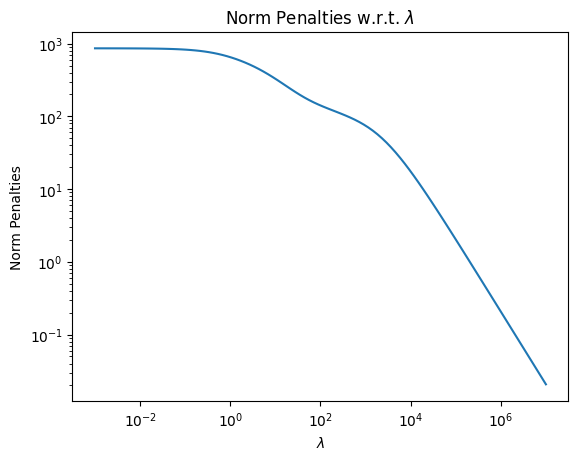

In [67]:
class Regression:
  def __init__(self):
    self.X = None
    self.y = None
    self.features = None

  def load_data(self):
    self.X = np.loadtxt("hitters/hitters.x.csv", delimiter = ",", skiprows = 1)

    with open("hitters/hitters.x.csv", "r") as f:
      self.features = next(csv.reader(f))

    self.y = np.loadtxt("hitters/hitters.y.csv", delimiter = ",", skiprows = 1)

    # Preprocess data
    SS = StandardScaler()
    self.X = SS.fit_transform(self.X)

    self.X = np.hstack((np.ones([np.shape(self.X)[0],1]), self.X))

  def solveRidgeRegression(self, X, y, lam):
    # Create A
    col_X = np.shape(X)[1]
    A = np.identity(col_X)
    A[0, 0] = 0

    # Close form solution according to previous task
    theta = np.linalg.inv(np.dot(X.T, X) + lam * A) @ np.transpose(X) @ y

    return theta
  
lam_array = np.logspace(-3, 7, 100)

reg = Regression()
reg.load_data()
# Create theta array and its norm array
theta_rr_array = np.zeros([np.shape(reg.X)[1], np.shape(lam_array)[0]])    # 20x100
norm_theta_array = np.zeros([1, np.shape(theta_rr_array)[1]])             # 1x100

# For every lambda, solve theta
for i in range(0, np.shape(theta_rr_array)[1]):
  # Perform Ridge Regression
  theta_rr_array[:, i] = reg.solveRidgeRegression(reg.X, reg.y, lam_array[i])
  # Calculate the norm of theta
  # Note: the first array is excluded, which represents the bias term
  norm_theta_array[0, i] = np.sqrt(np.sum(theta_rr_array[1: , i] ** 2))

plt.loglog(lam_array, norm_theta_array[0, :])
plt.xlabel("$\lambda$")
plt.ylabel("Norm Penalties")
plt.title("Norm Penalties w.r.t. $\lambda$")
plt.show()

### 4.

To compare the components between Least Square Regression and Ridge Regression, lets compute the Least Square Regression first.

In [68]:
class LSR(Regression):
  def solve_LeastSquareRegression(self):
    LinRe = lm.LinearRegression()
    LinRe.fit(self.X, self.y)
    return LinRe.coef_
  
lsr = LSR()
lsr.load_data()
theta_lsr = lsr.solve_LeastSquareRegression()

And then, print the $\mathbf{\theta}$ vector of Ridge Regressio with the smallest $\lambda$, and print the $\mathbf{\theta}$ vector of Least Square Regression

In [69]:
print("Ridge Regression")
print(theta_rr_array[:, 0])
print("Least Square Regression")
print(theta_lsr)

Ridge Regression
[ 535.92584411 -291.07689885  337.76983981   37.817637    -60.51643708
  -26.96167438  135.05922913  -16.72927386 -390.81338172   86.882135
  -14.05166346  480.42919877  260.45660149 -213.84040958   31.24937094
  -58.4169906    78.76124192   53.72488332  -22.16403075  -12.35251465]
Least Square Regression
[   0.         -291.09462584  337.83057573   37.85384355  -60.57253276
  -26.99496538  135.07394623  -16.69329665 -391.03867469   86.68713265
  -14.18188514  480.74772158  260.69007975 -213.8924465    31.24874897
  -58.41399362   78.76122932   53.73244107  -22.16080176  -12.34882979]


It can be seen that except the first term, the rest coeffecient is almost the same. This can also be shown with the subtraction of $\hat{\mathbf{\theta}}_{ls}$ and $\hat{\mathbf{\theta}}_{ridge}$:

In [70]:
print(theta_rr_array[:, 0] - theta_lsr)

[ 5.35925844e+02  1.77269975e-02 -6.07359232e-02 -3.62065513e-02
  5.60956785e-02  3.32910000e-02 -1.47171011e-02 -3.59772123e-02
  2.25292967e-01  1.95002344e-01  1.30221672e-01 -3.18522812e-01
 -2.33478259e-01  5.20369133e-02  6.21975491e-04 -2.99697362e-03
  1.26048117e-05 -7.55775105e-03 -3.22899183e-03 -3.68485864e-03]


it gives us a vector with all entries close to 0 except the bias term, so when $\lambda$ is very small, the results are pretty much the same. 

To further check how the coefficients change when $\lambda$ is getting larger, we can plot every coeffecient w.r.t. $\lambda$

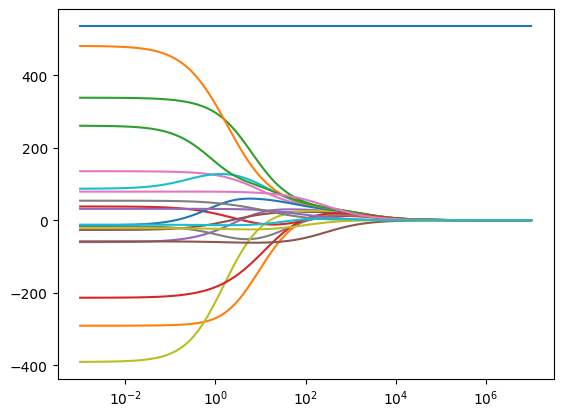

In [71]:
for i in range(0, theta_rr_array.shape[0]):
    plt.semilogx(lam_array, theta_rr_array[i, :])

### 5.

In [83]:
class KFoldCrossValidation(Regression):
  
  def __init__(self, K, hyperparameters):
    self.K = K
    self.lam_array = hyperparameters

  def folds_gen(self):
    self.fold_size = self.X.shape[0] // self.K
    
    self.folds_X = np.zeros([self.K, self.fold_size, self.X.shape[1]])
    self.folds_y = np.zeros([self.K, self.fold_size])
    
    for i in range(0, self.K):
      random_indices = np.random.choice(self.X.shape[0], self.fold_size, replace = False)
      
      self.folds_X[i, :, :] = self.X[random_indices]
      self.folds_y[i,:] = self.y[random_indices]
  
  # Assign training set and test sets
  def folds_assignment(self, n):
    self.X_train = self.folds_X[n, :, :]
    self.y_train = self.folds_y[n, :]

    self.test_index = []
    for i in range(self.K):
      if i != n:
        self.test_index.append(i)

    self.X_test = self.folds_X[self.test_index, :, :]
    self.y_test = self.folds_y[self.test_index, :]
  
KFCV = KFoldCrossValidation(5, lam_array)
KFCV.load_data()
KFCV.folds_gen()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
